In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=14)
plt.rc('figure', figsize=(12, 7))

Рассматривается задача о двухфазной фильтрации несжимаемых жидкостей &mdash; нефти и воды:
$$
\phi\frac{\partial s}{\partial t} - \frac{\partial}{\partial x} \left(K \frac{k_w(s)}{\mu_w} \frac{\partial p}{\partial x}\right) = 0\\
\phi\frac{\partial (1-s)}{\partial t} - \frac{\partial}{\partial x} \left(K \frac{k_o(s)}{\mu_o} \frac{\partial p}{\partial x}\right) = 0
$$
Здесь $s$ &mdash; водонасыщенность, $p$ &mdash; давление, $K, \phi$ &mdash; абсолютная проницаемость и пористость пласта, $k_r, k_w$ &mdash; относительные фазовые проницаемости, $\mu_w, \mu_o$ &mdash; вязкости воды и нефти.

Складывая эти уравнения, получаем уравнение для определения давления
$$
\frac{\partial}{\partial x} \left(
K\left(\frac{k_w(s)}{\mu_w} + \frac{k_o(s)}{\mu_o}\right)
\frac{\partial p}{\partial x}
\right) = 0
$$
После этого, вводя полную скорость фильтрации $W = -K\left(\frac{k_w(s)}{\mu_w} + \frac{k_o(s)}{\mu_o}\right)
\frac{\partial p}{\partial x}$, получаем нелинейное уравнение переноса для насыщенности:
$$
\phi\frac{\partial s}{\partial t} + \frac{\partial}{\partial x} \left(W \frac{\frac{k_w(s)}{\mu_w}}{\frac{k_w(s)}{\mu_w} + \frac{k_o(s)}{\mu_o}}\right) = 0\\
$$
Функция $\varphi(s) = \frac{k_w(s) / \mu_w}{k_w(s) / \mu_w + k_o(s) / \mu_o}$ показывает какая часть полного потока фильтрации приходится на водную фазу и называется функцией Баклея. Так как $W$ одинакова для всей области, уравнение можно записать как
$$
\frac{\partial s}{\partial t} + \frac{W}{\phi} \frac{\partial \varphi(s)}{\partial t} = 0.
$$
Это уравнение выражает собой закон сохранения, поэтому для его решения разумно применить консервативную схему. Воспользуемся простейшей явной противопоточной схемой:
$$
\frac{s^{n+1}_m - s^n_m}{\tau} + \frac{W}{\phi} \frac{\varphi(s^n_m) - \varphi(s^n_{m-1})}{h} = 0.
$$

In [2]:
# В этом классе содержится описание математической постановки задачи
class Problem(object):
    def __init__(self):
        self.phi = 0.05
        self.K   = 1
        self.muw = 1
        self.mul = 5
        self.pL  = 2
        self.pR  = 1
        self.D   = 1
        self.T   = 1
    def kw(self, s):
        return s*s
    def kl(self, s):
        return (1-s)**2
    def s0(self, x):
        return np.zeros_like(x)
    def sL(self, t):
        return 1

In [3]:
# В этом классе содержится информация о расчетной сетке и расчетные массивы
class Mesh(object):
    def __init__(self, M, prob):
        self.prob = prob
        z = np.linspace(0, prob.D, M+1)
        x = (z[:-1] + z[1:]) / 2
        assert len(x) == M
        self.x = x
        self.h = x[1] - x[0]
        self.s = np.empty_like(x)
        self.p = np.empty_like(x)
    def show(self):
        f = plt.figure(figsize=(16, 7))
        # pressure
        ax = f.add_subplot(1, 2, 1)
        ax.plot(self.x, self.p, 'r')
        ax.set_xlim(0, self.prob.D)
        ax.set_ylim(self.prob.pR, self.prob.pL)
        ax.set_title('Pressure')
        ax.grid()
        # saturation
        ax = f.add_subplot(1, 2, 2)
        ax.plot(self.x, self.s, 'b')
        ax.set_xlim(0, self.prob.D)
        ax.set_ylim(-0.05, 1.05)
        ax.set_title('Water saturation')
        ax.grid()

In [4]:
# В этом классе содержится реализация численного метода
class Solver(object):
    def __init__(self, prob, mesh):
        self.prob = prob
        self.mesh = mesh
        # Вычисляем максимальное значение \varphi'(s) для оценки шага по времени
        s = np.linspace(0, 1, 100)
        phi = self.buckley_function(s)
        dphids = np.diff(phi) / np.diff(s)        
        self.dphidsmax = dphids.max()
    def set_initial_cond(self):
        mesh = self.mesh
        prob = self.prob
        mesh.s = prob.s0(mesh.x)
    def buckley_function(self, s):
        aw = prob.kw(s) / prob.muw
        al = prob.kl(s) / prob.mul
        return aw / (aw + al)
    def estimate_timestep(self, C=0.8):
        # Оцениваем dt из условия Куранта lambda_max dt / h = C <= 1
        lam = mesh.W[0] / prob.phi * self.dphidsmax
        return C * mesh.h / lam
    def solve_pressure(self):
        mesh = self.mesh
        prob = self.prob
        
        # Строим трёхдиагональную разностную аппроксимацию уравнения и решаем
        # c помощью ленточного солвера из scipy
        sbnd = (mesh.s[:-1] + mesh.s[1:]) / 2
        b = prob.kw(sbnd) / prob.muw + prob.kl(sbnd) / prob.mul
        
        M = len(mesh.x)
        matrix = np.zeros((3, M))
        rhs    = np.zeros(M)
        
        matrix[1, 0]    = matrix[1, -1] = 1
        matrix[0, 2:]   = b[1:]
        matrix[1, 1:-1] = -b[1:] - b[:-1]
        matrix[2, :-2]  = b[:-1]
        rhs[0]  = prob.pL
        rhs[-1] = prob.pR
        
        mesh.p = la.solve_banded((1, 1), matrix, rhs)
        mesh.W = -prob.K * b * np.diff(mesh.p) / mesh.h
        
    def advect_saturation(self, t, dt):
        mesh = self.mesh
        prob = self.prob
        
        W = mesh.W[0]
        M = len(mesh.x)
        
        # Консервативная противопоточная схема
        flux = self.buckley_function(mesh.s)
        for m in range(1, M):
            mesh.s[m] -= dt*W/prob.phi * (flux[m] - flux[m-1])/mesh.h
        
        # Граничное условие слева
        mesh.s[0] = prob.sL(t + dt)

In [5]:
prob = Problem()
mesh = Mesh(1000, prob)
solver = Solver(prob, mesh)

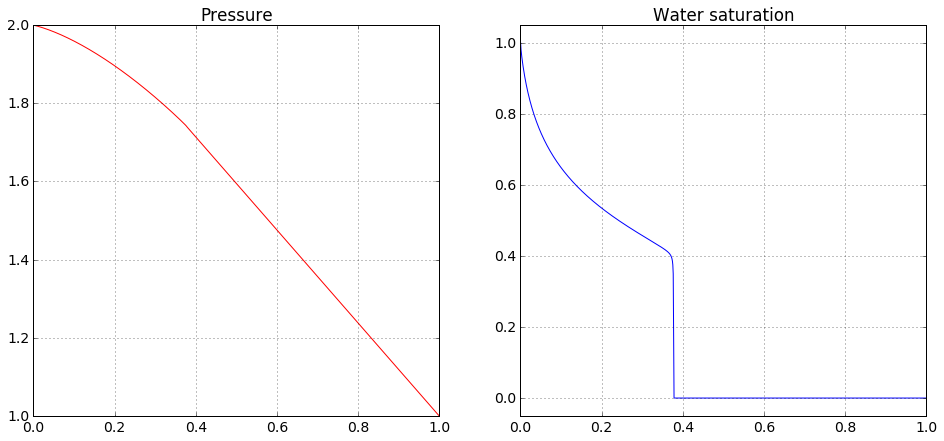

In [6]:
solver.set_initial_cond()
t = 0
while t < 0.05:
    solver.solve_pressure()
    dt = solver.estimate_timestep(C=0.9)
    solver.advect_saturation(t, dt)
    t += dt
    
mesh.show()

Для сравнения это же уравнение можно решить аналитически. Пусть $q = \int_0^t \frac{W(\xi)}{\phi} d\xi$. Здесь учтен тот факт, что скорость фильтрации непостоянна и может меняться во времени. Тогда уравнение упрощается до
$$
\frac{\partial s}{\partial q} + \frac{\partial \varphi(s)}{\partial x} = 0,\\
\frac{\partial s}{\partial q} + \varphi'(s) \frac{\partial s}{\partial x} = 0.
$$
Последнее уравнение может быть решено с помощью метода характеристик. Решение состоит из центрированной волны, скачка и области $s = 0$. В центрированной волне точка со значением $s$ переносится со скоростью $\varphi'(s)$, то есть имеет координату
$$
x(s) = q \varphi'(s).
$$
Это задает $s(x)$ в виде обратной функции:
$$
s(x) = (\varphi')^{-1}\left(\frac{x}{q}\right).
$$
Однако, при необходимость построить график намного проще строить $x(s)$ вместо $s(x)$.

Центрированная волна существует в диапазоне $s \in [s^*, 1]$, перед волной движется скачкообразный фронт вытеснения, в котором насыщенность скачком меняется от $[0, s^*]$. 

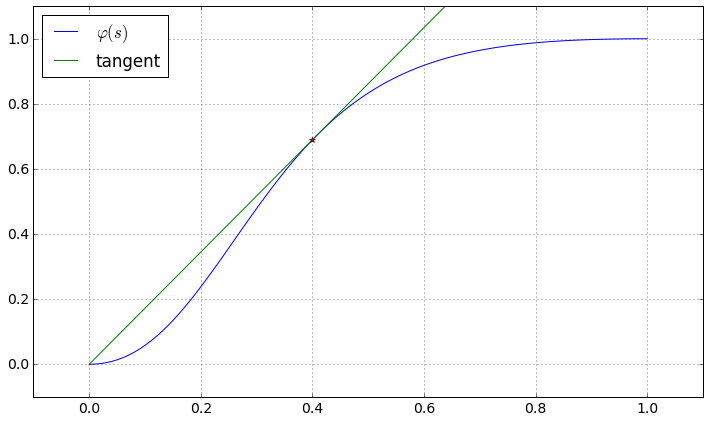

In [8]:
s = np.linspace(0, 1, 100)
plt.plot(s, solver.buckley_function(s), label=r'$\varphi(s)$')
sstar = 0.4;
plt.plot(s, solver.buckley_function(sstar)/sstar*s, label='tangent') # касательная "на глаз"
plt.plot([sstar], solver.buckley_function(sstar), '*')
plt.legend(loc='best')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid()

<h2 style="color:red;">Задание 1</h2>

Численно построить касательную к функции Баклея и найти $s^*$ (решить уравнение $\varphi'(s^*) = \frac{\varphi(s^*)}{s^*}$). Вычислить координаты фронта вытеснения в момент времени $t$. Для этого добавить в солвер вычисление величины $q$. Убедиться, что численный фронт находится в правильной точке.

<h2 style="color:red;">Задание 2</h2>

Нарушить условие Куранта $C < 1$. Теряется ли при этом устойчивость численного метода? К каким негативным последствиям приводит нарушение условия Куранта в данной задаче?